In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import requests
import json
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

state_lockdown_file = pd.read_csv("data_sources/lockdown_us.csv")
state_deaths_cases_file = pd.read_csv("data_sources/liz-friedman-us-covid-19-data-from-nytimes/us-states.csv")
county_population_file = pd.read_csv("data_sources/qventus-covid-19-localized-scenario-planner/qventus-covid-19-localized-scenario-planner/covid_county_population_usafacts.csv")


In [33]:
url = "https://api.covidtracking.com/v1/states/current.json"
state_current_data = (requests.get(url)).json()
state_current_data=pd.DataFrame(state_current_data)
state_current_data['date'] = pd.to_datetime(state_current_data['date'], format='%Y%m%d')


In [34]:
url = "https://api.covidtracking.com/v1/states/daily.json"
state_daily_data = (requests.get(url)).json()
state_daily_data=pd.DataFrame(state_daily_data)
state_daily_data['date'] = pd.to_datetime(state_daily_data['date'], format='%Y%m%d')
state_daily_data = state_daily_data.set_index("state")
state_daily_data = state_daily_data.drop(["AS","GU","MP","PR", "VI","DC"])
state_daily_data = state_daily_data.reset_index()

#loop for summing for total state cases
states = state_daily_data["state"].unique()
total_cases_by_state = []


for state in states:
    state_case = state_daily_data.loc[state_daily_data["state"] == state]
    total_cases_by_state.append(state_case["positive"].sum())

total_cases_by_state

[260643.0,
 6567677.0,
 3204212.0,
 11898395.0,
 38089071.0,
 4628095.0,
 6019186.0,
 1523901.0,
 31944399.0,
 14834082.0,
 251356.0,
 4036439.0,
 1460175.0,
 19093001.0,
 6539787.0,
 2368535.0,
 2580047.0,
 10058911.0,
 14089051.0,
 8828171.0,
 402647.0,
 10609905.0,
 5002525.0,
 4073235.0,
 4585697.0,
 294218.0,
 9525611.0,
 588977.0,
 2455237.0,
 708826.0,
 23030342.0,
 1728813.0,
 3565433.0,
 54620675.0,
 7974329.0,
 2740065.0,
 1480520.0,
 12000112.0,
 2195423.0,
 6279481.0,
 900971.0,
 8063342.0,
 30483461.0,
 3197597.0,
 8421601.0,
 174509.0,
 5501312.0,
 4883848.0,
 547730.0,
 231939.0]

In [35]:
#loop for finding positive rate per month


months = [1,2,3,4,5,6,7,8]
positive_rates = []
state_list = []
month_list = []

for state in states:
    
    single_state = state_daily_data.loc[state_daily_data["state"] == state]
    single_state['date'] = pd.to_datetime(single_state['date'], format='%Y%m%d')    
    single_state = single_state.sort_values("date")
    single_state['month'] = pd.DatetimeIndex(single_state['date']).month
    single_state['day'] = pd.DatetimeIndex(single_state['date']).day
    for month in months:
        print(state)
        try:
            single_month = single_state.loc[single_state["month"] == month]
            single_month = single_month.reset_index()
            first_row = single_month.iloc[0]
            last_row = single_month.iloc[-1]
            month_pos = int(last_row["positive"]) - int(first_row["positive"])
            month_tot = int(last_row["posNeg"]) - int(first_row["posNeg"])
            positive_rate = month_pos / month_tot
            positive_rate = "{:.2%}".format(positive_rate)
            positive_rates.append(positive_rate)
            state_list.append(state)
            month_list.append(month)
            
            
        except IndexError:
            print("no data for this month")
        except ValueError:
            print("value issue")
        except ZeroDivisionError:
            print("month total = 0")

AK
no data for this month
AK
no data for this month
AK
AK
AK
AK
AK
AK
AL
no data for this month
AL
no data for this month
AL
AL
AL
AL
AL
AL
AR
no data for this month
AR
no data for this month
AR
AR
AR
AR
AR
AR
AZ
no data for this month
AZ
no data for this month
AZ
AZ
AZ
AZ
AZ
AZ
CA
no data for this month
CA
no data for this month
CA
CA
CA
CA
CA
CA
CO
no data for this month
CO
no data for this month
CO
CO
CO
CO
CO
CO
CT
no data for this month
CT
no data for this month
CT
CT
CT
CT
CT
CT
DE
no data for this month
DE
no data for this month
DE
DE
DE
DE
DE
DE
FL
no data for this month
FL
no data for this month
FL
FL
FL
FL
FL
FL
GA
no data for this month
GA
no data for this month
GA
GA
GA
GA
GA
GA
HI
no data for this month
HI
no data for this month
HI
HI
HI
HI
HI
HI
IA
no data for this month
IA
no data for this month
IA
IA
IA
IA
IA
IA
ID
no data for this month
ID
no data for this month
ID
ID
ID
ID
ID
ID
IL
no data for this month
IL
no data for this month
IL
IL
IL
IL
IL
IL
IN
no data for this 

In [36]:
pos_rates_df = pd.DataFrame({
    "State": state_list,
    "Positive Rate": positive_rates,
    "Month": month_list
})
pos_rates_df.head(500)

,State,Positive Rate,Month
0,AK,3.21%,3
1,AK,1.53%,4
2,AK,0.22%,5
3,AK,0.82%,6
4,AK,2.27%,7
...,...,...,...
293,WY,5.83%,4
294,WY,2.34%,5
295,WY,6.77%,6
296,WY,6.18%,7


In [37]:
#States total population
state_pop = []
states = county_population_file["State"].unique()

for state in states:
    state_df = county_population_file.loc[county_population_file["State"] == state]
    state_pop.append(state_df["population"].sum())
    
population_df = pd.DataFrame({
    "state": states,
    "population": state_pop
})



In [38]:
state_deaths_cases_file.head()
state_deaths_cases_file = state_deaths_cases_file.rename(columns={"state":"State"})
state_deaths_cases_file = state_deaths_cases_file.sort_values("State")

state_deaths_cases_file['month'] = pd.DatetimeIndex(state_deaths_cases_file['date']).month
state_deaths_cases_file['day'] = pd.DatetimeIndex(state_deaths_cases_file['date']).day

state_deaths_cases_file.head()

,date,State,fips,cases,deaths,month,day
2874,2020-04-24,Alabama,1,6026,209,4,24
7549,2020-07-18,Alabama,1,65234,1286,7,18
3589,2020-05-07,Alabama,1,9046,369,5,7
3699,2020-05-09,Alabama,1,9668,390,5,9
9254,2020-08-18,Alabama,1,110361,1936,8,18


In [39]:
state_deaths_cases_file = state_deaths_cases_file.dropna()
state_deaths_cases_file = state_deaths_cases_file.set_index("State")
state_deaths_cases_file.head()

,date,fips,cases,deaths,month,day
State,,,,,,
Alabama,2020-04-24,1,6026,209,4,24
Alabama,2020-07-18,1,65234,1286,7,18
Alabama,2020-05-07,1,9046,369,5,7
Alabama,2020-05-09,1,9668,390,5,9
Alabama,2020-08-18,1,110361,1936,8,18


In [43]:
first_state_deaths_cases_file = state_deaths_cases_file.loc[["Arizona","Florida","Kansas",
                                                       "New York","Washington","Wisconsin"],["date","deaths"]]
first_state_deaths_cases_file

,date,deaths
State,,
Arizona,2020-08-05,3933
Arizona,2020-03-10,0
Arizona,2020-05-29,885
Arizona,2020-03-18,0
Arizona,2020-06-13,1190
...,...,...
Wisconsin,2020-08-11,1017
Wisconsin,2020-04-29,308
Wisconsin,2020-07-25,900


In [10]:
positive_closings = state_deaths_cases_file.loc[["California","Florida","New York", 
                                                "Kansas","Texas","Washington"],
                                                ["date","cases","month"]]
positive_closings = positive_closings.sort_values("date")
positive_closings.head()

,date,cases,month
State,,,
Washington,2020-01-21,1,1
Washington,2020-01-22,1,1
Washington,2020-01-23,1,1
Washington,2020-01-24,1,1
Washington,2020-01-25,1,1


In [11]:
california = positive_closings.loc["California"]
cali_closings = california.loc[(california["date"] >= "2020-03-19"),:]
cali_closings = california.loc[(california["date"] <= "2020-05-12"),:]
cali_closings = cali_closings.groupby(by=["month"]).agg(sum)

kansas = positive_closings.loc["Kansas"]
ks_closings = kansas.loc[(kansas["date"]>= "2020-04-19"),:]
ks_closings = kansas.loc[(kansas["date"]<= "2020-05-03"),:]
ks_closings = ks_closings.groupby(by=["month"]).agg(sum)

florida = positive_closings.loc["Florida"]
fl_closings = florida.loc[(florida["date"]>= "2020-04-03"),:]
fl_closings = florida.loc[(florida["date"]<= "2020-04-30"),:]
fl_closings = fl_closings.groupby(by=["month"]).agg(sum)

new_york = positive_closings.loc["New York"]
ny_closings = new_york.loc[(new_york["date"]>= "2020-03-22"),:]
ny_closings = new_york.loc[(new_york["date"]<= "2020-05-15"),:]
ny_closings = ny_closings.groupby(by=["month"]).agg(sum)

washington = positive_closings.loc["Washington"]
wa_closings = washington.loc[(washington["date"]>= "2020-03-23"),:]
wa_closings = washington.loc[(washington["date"]<= "2020-05-04"),:]
wa_closings = wa_closings.groupby(by=["month"]).agg(sum)

texas = positive_closings.loc["Texas"]
tx_closings = texas.loc[(texas["date"]>= "2020-04-02"),:]
tx_closings = texas.loc[(texas["date"]<= "2020-04-30"),:]
tx_closings = tx_closings.groupby(by=["month"]).agg(sum)

In [12]:
cali_reo = california.loc[(california["date"] >= "2020-05-12"),:]
cali_reo = cali_reo.groupby(by=["month"]).agg(sum)

ks_reo = kansas.loc[(kansas["date"]>= "2020-05-03"),:]
ks_reo = ks_reo.groupby(by=["month"]).agg(sum)

fl_reo = florida.loc[(florida["date"]>= "2020-04-30"),:]
fl_reo = fl_reo.groupby(by=["month"]).agg(sum)

ny_reo = new_york.loc[(new_york["date"]>= "2020-05-15"),:]
ny_reo = ny_reo.groupby(by=["month"]).agg(sum)

wa_reo = washington.loc[(washington["date"]>= "2020-05-04"),:]
wa_reo = wa_reo.groupby(by=["month"]).agg(sum)

tx_reo = texas.loc[(texas["date"]>= "2020-04-30"),:]
tx_reo = tx_reo.groupby(by=["month"]).agg(sum)

In [13]:
ks_data = first_state_deaths_cases_file.loc[["Kansas"],["date","deaths"]]
ks_data=ks_data.sort_values("deaths")

In [44]:
state_lockdown_file[pd.isnull(state_lockdown_file['County'])]
state_lockdown_file[pd.isnull(state_lockdown_file['Type'])]

state_lockdown_file['month'] = pd.DatetimeIndex(state_lockdown_file['Date']).month
state_lockdown_file['day'] = pd.DatetimeIndex(state_lockdown_file['Date']).day

state_lockdown_file

,Country,State,County,Date,Type,month,day
0,United States,Alabama,NaN,2020-04-04,Stay at home,4,4
1,United States,Alabama,Birmingham,2020-03-24,Shelter in place,3,24
2,United States,Alaska,NaN,2020-03-28,Stay at home,3,28
3,United States,Arizona,NaN,2020-03-31,Stay at home,3,31
4,United States,California,NaN,2020-03-19,Stay at home,3,19
...,...,...,...,...,...,...,...
168,United States,Virginia,NaN,2020-03-30,Stay at home,3,30
169,United States,Washington,NaN,2020-03-23,Stay at home,3,23
170,United States,West Virginia,NaN,2020-03-24,Stay at home,3,24
171,United States,Wisconsin,NaN,2020-03-25,Stay at home,3,25


In [15]:
state_current_narrow = state_current_data[["state","positive","death","hospitalized"]]
state_current_drop = state_current_narrow.dropna()
state_current_drop
state_current_drop = state_current_drop.set_index('state')
state_current_drop

state_current_df = pd.merge(state_current_drop, population_df, on='state')
state_current_df.head()

,state,positive,death,hospitalized,population
0,AL,126058,2182,14267.0,4903185
1,AR,61224,797,4213.0,3017804
2,AZ,201835,5029,21405.0,7278717
3,CO,57223,1843,7010.0,5758736
4,CT,52879,4465,11180.0,3565287


In [16]:
special_states_data = state_current_drop.loc[["AZ","FL","KS","NY","WA","WI"],["death","hospitalized"]]
special_states_data

,death,hospitalized
state,,
AZ,5029,21405.0
FL,11331,38942.0
KS,446,2304.0
NY,25328,89995.0
WA,1905,6740.0
WI,1130,5817.0


In [17]:
states_early_lock = state_current_drop.loc[["KY","MA","NY","WA","WI"],["death","hospitalized"]]
states_early_lock

states_late_lock = state_current_drop.loc[["FL","GA","KS","SC","AZ"],["death","hospitalized"]]
states_late_lock


,death,hospitalized
state,,
FL,11331,38942.0
GA,5632,24604.0
KS,446,2304.0
SC,2720,7811.0
AZ,5029,21405.0


Text(0.5, 1.0, 'Comparing States by Deaths and Hospitalizations Due to COVID-19')

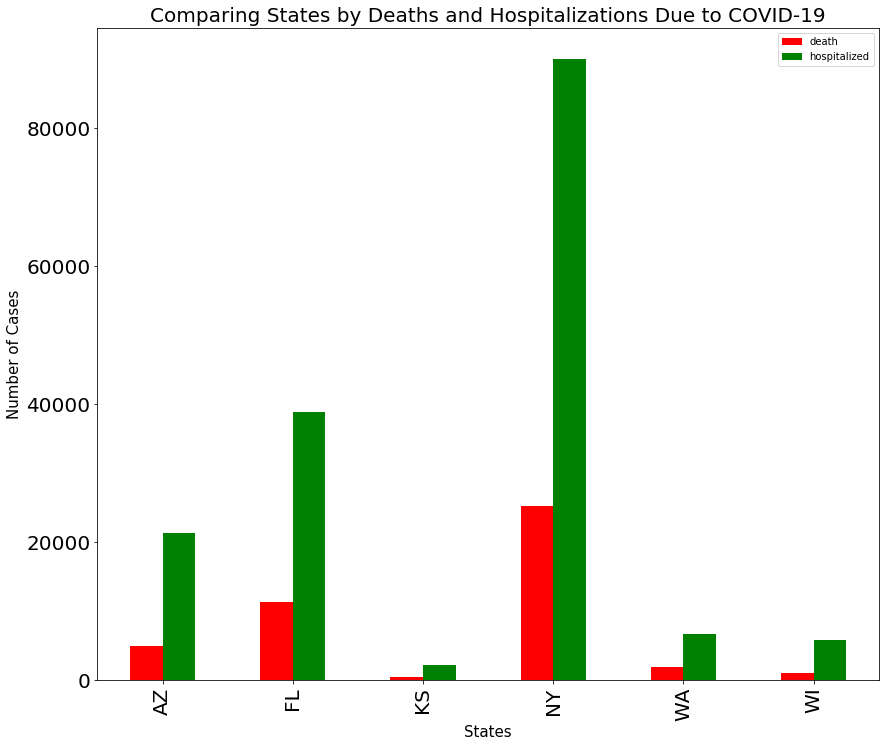

In [18]:
my_colors = "rgbkymc"
plot_pandas = special_states_data.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to COVID-19", fontsize=20)

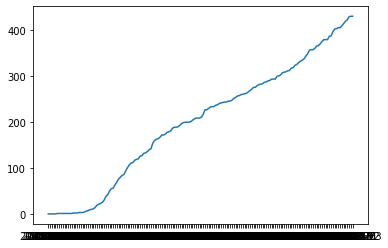

In [19]:
plt.plot(ks_data["date"],ks_data["deaths"])

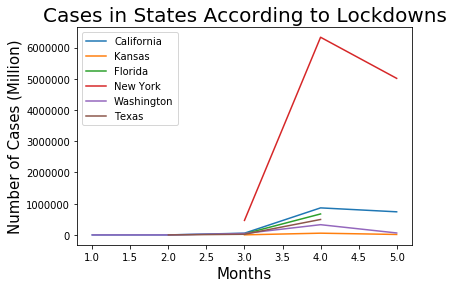

<Figure size 432x288 with 0 Axes>

In [20]:
cali_handle_1 = plt.plot(cali_closings, label="California")
ks_handle_1 = plt.plot(ks_closings, label="Kansas")
fl_handle_1 = plt.plot(fl_closings,label="Florida")
ny_handle_1 = plt.plot(ny_closings, label="New York")
wa_handle_1 = plt.plot(wa_closings, label="Washington")
tx_handle_1 = plt.plot(tx_closings, label="Texas")
#(handles=[cali_handle_1,ks_handle_1,fl_handle_1,ny_handle_1,wa_handle_1,tx_handle_1],loc="best")
plt.legend(loc="best")
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of Cases (Million)", fontsize=15)
plt.title("Cases in States According to Lockdowns", fontsize=20)
plt.show()
plt.tight_layout()

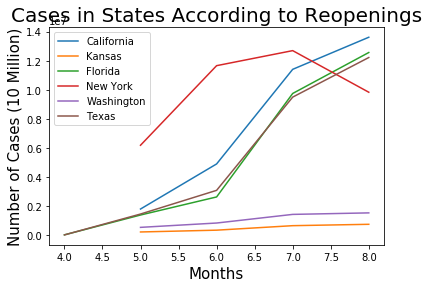

<Figure size 432x288 with 0 Axes>

In [21]:
cali_handle_2 = plt.plot(cali_reo, label="California")
ks_handle_2 = plt.plot(ks_reo, label="Kansas")
fl_handle_2 = plt.plot(fl_reo,label="Florida")
ny_handle_2 = plt.plot(ny_reo, label="New York")
wa_handle_2 = plt.plot(wa_reo, label="Washington")
tx_handle_2 = plt.plot(tx_reo, label="Texas")
plt.legend(loc="best")
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of Cases (10 Million)", fontsize=15)
plt.title("Cases in States According to Reopenings", fontsize=20)
plt.show()
plt.tight_layout()

Text(0.5, 1.0, 'Comparing States by Deaths and Hospitalizations Due to Early Lockdown')

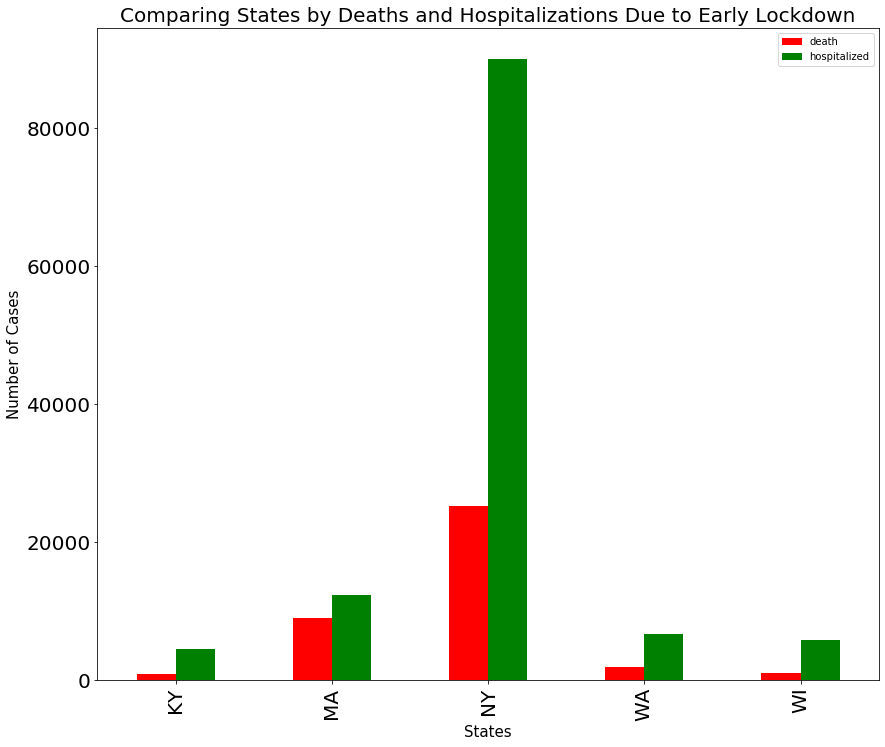

In [22]:
my_colors = "rgbkymc"
plot_pandas = states_early_lock.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to Early Lockdown", fontsize=20)

Text(0.5, 1.0, 'Comparing States by Deaths and Hospitalizations Due to Early Lockdown')

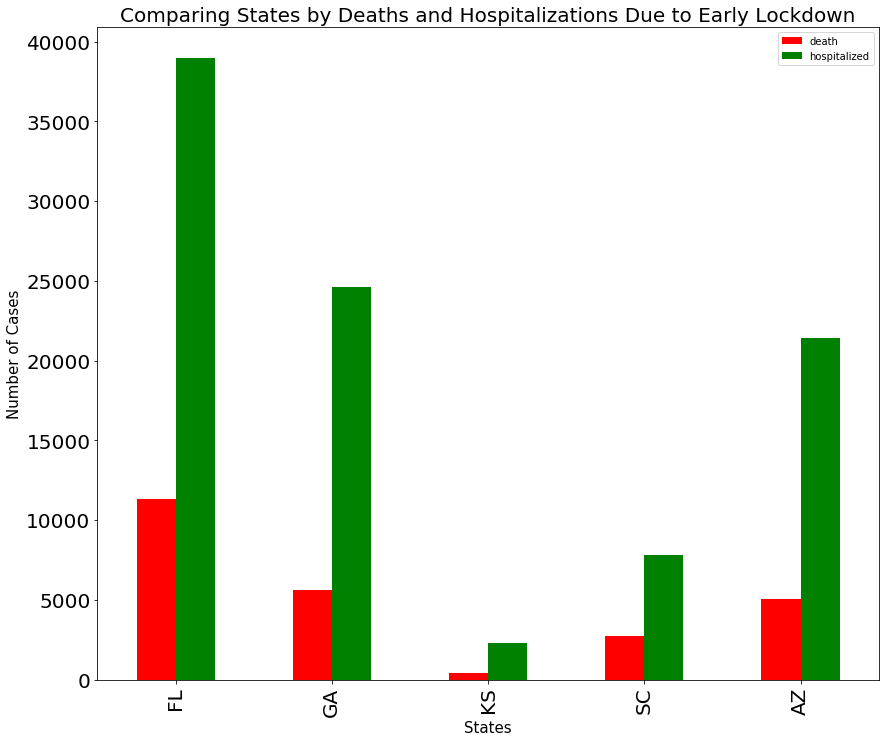

In [23]:
my_colors = "rgbkymc"
plot_pandas = states_late_lock.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to Early Lockdown", fontsize=20)

In [24]:
summer_fun = state_deaths_cases_file.loc[["California","Florida","Hawaii",
                                                "Missouri","Texas","Nevada"],
                                                ["date","cases","month"]]

In [25]:
california_summer = summer_fun.loc["California"]
cali_summer = california_summer.loc[(california_summer["date"] >= "2020-05-25"),:]
cali_summer = california_summer.loc[(california_summer["date"] <= "2020-09-07"),:]
cali_summer = cali_summer.groupby(by=["month"]).agg(sum)
hawaii_summer = summer_fun.loc["Hawaii"]
hi_summer = hawaii_summer.loc[(hawaii_summer["date"] >= "2020-05-25"),:]
hi_summer = hawaii_summer.loc[(hawaii_summer["date"] <= "2020-09-07"),:]
hi_summer = hi_summer.groupby(by=["month"]).agg(sum)
florida_summer = summer_fun.loc["Florida"]
fl_summer = florida_summer.loc[(florida_summer["date"] >= "2020-05-25"),:]
fl_summer = florida_summer.loc[(florida_summer["date"] <= "2020-09-07"),:]
fl_summer = fl_summer.groupby(by=["month"]).agg(sum)
missouri_summer = summer_fun.loc["Missouri"]
mo_summer = missouri_summer.loc[(missouri_summer["date"] >= "2020-05-25"),:]
mo_summer = missouri_summer.loc[(missouri_summer["date"] <= "2020-09-07"),:]
mo_summer = mo_summer.groupby(by=["month"]).agg(sum)
nevada_summer = summer_fun.loc["Nevada"]
nv_summer = nevada_summer.loc[(nevada_summer["date"] >= "2020-05-25"),:]
nv_summer = nevada_summer.loc[(nevada_summer["date"] <= "2020-09-07"),:]
nv_summer = nv_summer.groupby(by=["month"]).agg(sum)
texas_summer = summer_fun.loc["Texas"]
tx_summer = texas_summer.loc[(texas_summer["date"] >= "2020-05-25"),:]
tx_summer = texas_summer.loc[(texas_summer["date"] <= "2020-09-07"),:]
tx_summer = tx_summer.groupby(by=["month"]).agg(sum)


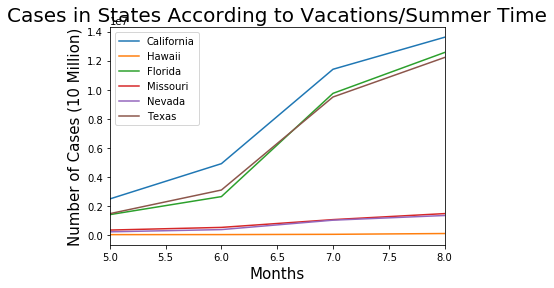

<Figure size 432x288 with 0 Axes>

In [26]:
cali_handle_3 = plt.plot(cali_summer, label="California")
hi_handle_3 = plt.plot(hi_summer, label="Hawaii")
fl_handle_3 = plt.plot(fl_summer,label="Florida")
mo_handle_3 = plt.plot(mo_summer, label="Missouri")
nv_handle_3 = plt.plot(nv_summer, label="Nevada")
tx_handle_3 = plt.plot(tx_summer, label="Texas")
plt.legend(loc = "best")
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of Cases (10 Million)", fontsize=15)
plt.title("Cases in States According to Vacations/Summer Time", fontsize=20)
plt.xlim(5,8)
plt.show()
plt.tight_layout()